# Finite-Time Lyapunov Exponents

Code taken from <a href="https://github.com/LauraGomezNavarro/OceanParcels_Lyapunov" target="_blank">here</a> 

In [1]:
import time
print(time.ctime(time.time()))

Wed Jan 31 13:59:40 2024


### 0. Import packages

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as features
from matplotlib import colors
import sys
from tqdm import tqdm

### 1. Loading data

In [ ]:
DATA_FOLDER = '../../Simulations'

**Td: Time in days selected to get the location of particles after release**

In [4]:
Td=15

In [ ]:
import numpy as np  
import numpy.linalg as LA


import numpy as np


def haversine_displacement(inlon1, inlon2, inlat1, inlat2):
    """
    Parallelised code from - Michael Denes
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """

    #Convert decimal degrees to Radians:
    lon1 = np.radians(inlon1)
    lat1 = np.radians(inlat1)
    lon2 = np.radians(inlon2)
    lat2 = np.radians(inlat2)

    # if np.isnan([lon1, lon2, lat1, lat2]).any():
    #     return mask_value
    #Implementing Haversine Formula:
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),
                          np.multiply(np.cos(lat1),
                                      np.multiply(np.cos(lat2),
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    c = np.multiply(2, np.arcsin(np.sqrt(a)))
    return c

def ftle_brunton_2009(J, Td):
    # http://cwrowley.princeton.edu/papers/BruntonChaos09.pdf
    D = np.dot(np.transpose(J), J)  # Cauchy–Green strain tensor
    lamda = LA.eigvals(D)
    lam_max = max(lamda)
    ftle = (1/Td)*np.log(np.sqrt(lam_max))
    return ftle


def ftle_compute(x0, y0, x1, y1, Td):
    """Compute Finite-time Lyaponov Exponent function from locations of Lagrangian trajectories at the intial and a later timestep

    Parameters
    ----------
    x0: meshgrid of initial longitude points
    y0: meshgrid of initial latitude points
    x1: meshgrid of final longitude points
    y1: meshgrid of final latitude points
    Td : number of days between inital and final timestamps

    Returns
    -------
    2D array
    Computed FTLE for the whole set of points
    """
    H = x0.shape[0]
    L = x1.shape[1]

    FTLE_f = np.ones_like(np.asarray(x0))
    FTLE_f[:, :] = np.NaN

    J = np.empty([2, 2], float)

    # 1, H-1 --> to ignore bordersx for now
    for i in range(1, H - 1):  # 0, H-2
        for j in range(1, L - 1):  # 0, L-2
            J[:, :] = np.NaN
            ls = np.array((x0[i, j], y0[i, j],
                        x0[i - 1, j], y0[i - 1, j],
                        x0[i, j - 1], y0[i, j - 1],
                        x0[i, j + 1], y0[i, j + 1],
                        x0[i + 1, j], y0[i + 1, j],
                        x1[i, j], y1[i, j],
                        x1[i - 1, j], y1[i - 1, j],
                        x1[i, j - 1], y1[i, j - 1],
                        x1[i, j + 1], y1[i, j + 1],
                        x1[i + 1, j], y1[i + 1, j]))
            if np.isnan(ls).any():
                continue

            J[0][0] = haversine_displacement(x1[i, j], x1[i - 1, j], y1[i, j], y1[i - 1, j]) / \
                haversine_displacement(x0[i, j], x0[i - 1, j], y0[i, j], y0[i - 1, j])
            J[0][1] = haversine_displacement(x1[i, j], x1[i, j - 1], y1[i, j], y1[i, j - 1]) / \
                haversine_displacement(x0[i, j], x0[i, j - 1], y0[i, j], y0[i, j - 1])
            J[1][0] = haversine_displacement(x1[i, j], x1[i, j + 1], y1[i, j], y1[i, j + 1]) / \
                haversine_displacement(x0[i, j], x0[i, j + 1], y0[i, j], y0[i, j + 1])
            J[1][1] = haversine_displacement(x1[i, j], x1[i + 1, j], y1[i, j], y1[i + 1, j]) / \
                haversine_displacement(x0[i, j], x0[i + 1, j], y0[i, j], y0[i + 1, j])
            f_value = ftle_brunton_2009(J, Td)
            FTLE_f[i][j] = f_value

    print(np.nanmin(FTLE_f), np.nanmax(FTLE_f))
    return FTLE_f


In [ ]:

ds = xr.open_dataset(DATA_FOLDER + 'Simulations/toy_data_01.nc')

Get release particles from the meshgrid for release particles 

In [7]:
# hard coded here, as its not possible to tell from the parcels output files itself.
coords0, coords1 = 12, 12

# initial position
x0 = np.reshape(ds['lon'][:,0].data, (coords0, coords1))
y0 = np.reshape(ds['lat'][:,0].data, (coords0, coords1)) 

# final position
x1 = np.reshape(ds['lon'][:,-1].data, (coords0, coords1))
y1 = np.reshape(ds['lat'][:,-1].data, (coords0, coords1))

In [8]:
H = x0.shape[0]
L = x1.shape[1]
FTLE_f = np.ones_like(np.asarray(x0))
FTLE_f[:,:] = np.NaN

### 2. Estimate FTLE

In [ ]:
ftle_array = ftle_compute(x0, y0, x1, y1, Td)

0.13078183 0.27300894


### 3. Plotting
Plot FTLE values at the release locations

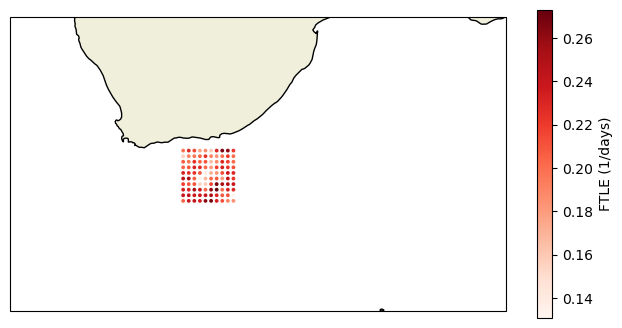

In [ ]:
# ftle_array = ftle_compute(x0,y0,x1,y1, Td)
fig = plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(features.LAND)
ax.add_feature(features.COASTLINE)
plt.scatter(ds['lon'][:,0], ds['lat'][:,0], c=ftle_array, cmap='Reds', s=3)
ax.set_xlim(10, 47)
ax.set_ylim(-47, -25)
cbar = plt.colorbar()
cbar.set_label("FTLE (1/days)")


**Land mass in the release grid**

If the region you are interested in also has a land mass, you can do the following:

1. Create a regular array of particle locations over the whole area (land and water).
2. Use the land mask from the ocean model data to create a boolean matrix corresponding to the released particles and extract the ocean only particles.
3. After the simulation, use the boolean mask array to map the released particles initial (and final) locations to an array of the boolean matrix shape. Non-ocean particles are set to NAN.
